# Imports

In [1]:
from IPython import get_ipython
get_ipython().run_line_magic('reload_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from PIL import Image
import cv2
import albumentations as A
from scipy.signal import convolve2d
from src.config import PATH, DATA_DIR, MODELS_DIR

In [3]:
IMAGE_SHAPE = [256,256]
EXAMPLES_DIR = DATA_DIR / 'examples'
# MODEL_PATH = MODELS_DIR / '2021-10-05 1618' / '200E'
# MODEL_PATH = MODELS_DIR / '2021-10-06 1343' / '200E'
MODEL_PATH = MODELS_DIR / '2021-10-13 1327' / '150E'

In [4]:
# we only want the generator
model = tf.keras.models.load_model(MODEL_PATH)
model = model.generator

# Plotting Functions

In [5]:
def decode_sketch(sketch_path, image_shape, resize_method):
    # takes a png file path and returns a tensor
    sketch = tf.io.read_file(sketch_path)
    sketch = tf.io.decode_png(sketch)
    sketch = tf.cast(sketch, tf.float32) / 255
    sketch = tf.image.resize(sketch, image_shape, method=resize_method)
    return sketch

def thicken_sketch(sketch, filter_size=3):
    # what background=0, lines=1
    sketch = 1-sketch
    
    print('thickening')
    
    # perform convolution
    conv_filter = np.ones([filter_size,filter_size])
    conv_image = convolve2d(sketch, conv_filter, mode='same')
    
    # convert back to binary
    conv_image[conv_image <  0.9] = 0
    conv_image[conv_image >= 0.9] = 1
    
    # reset background to 1
    conv_image = 1-conv_image
    return conv_image

def data_augmentation(image, image_size):    
    # Instantiate augmentations - jitter, rotate, mirror
    transforms = A.Compose([
        A.PadIfNeeded(min_height=image_size[0]+20, min_width=image_size[1]+20, border_mode=cv2.BORDER_CONSTANT, value=[1,1,1]),
        A.Rotate(limit=40, border_mode=cv2.BORDER_CONSTANT, value=[1,1,1]),
        A.RandomCrop(*image_size),
        A.HorizontalFlip()])
    
    data = {"image":image}
    aug_data = transforms(**data)
    aug_image = aug_data["image"]
    
    return aug_image

In [6]:
def show_prediction(img, pred, size):
    """Take the sketch and prediction and plot alongside"""
    fig, axs = plt.subplots(1, 2, figsize=(size*2, size*1))

    axs[0].imshow(img.numpy(), cmap='gray')
    axs[1].imshow((pred.numpy().squeeze()+1)/2)

    # remove axis ticks
    for ax in matplotlib.cbook.flatten(axs):
        ax.set(xticks=[], yticks=[])

    # set titles
    axs[0].set_title('Sketch')
    axs[1].set_title('Prediction')

    # adjust styling and show
    fig.patch.set_facecolor('white')     
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()
    plt.close()

In [7]:
def predict_and_show(model, filepath, image_shape=[128,128], size=3, resize_method='area', threshold=0.9, thicken=0, aug=False, save=False, show=True):
    """Resizing with method=area does much much better on the MSPaint examples"""
    
    # load file and make prediction
    sketch = decode_sketch(str(filepath), image_shape, resize_method)
    
    # hand drawn sketches need extra preprocessing
    if sketch.shape[-1]==3:
        sketch = tf.image.rgb_to_grayscale(sketch)
        sketch = sketch.numpy()[:,:,0]
        sketch[sketch <  threshold] = 0
        sketch[sketch >= threshold] = 1
        if thicken:
            sketch = thicken_sketch(sketch, filter_size=thicken)
        if aug:
            sketch = data_augmentation(sketch[:,:,np.newaxis], image_shape)
        sketch = tf.constant(sketch)
    
    # predict and plot
    image = model(sketch[tf.newaxis, ...])
    if save:
        img = (image.numpy().squeeze()+1)/2
        img = (img*256).astype(np.uint8)
        img = Image.fromarray(img)
        img.save(save)
    if show:
        show_prediction(sketch, image, size)

# Plotting

In [31]:
# for layer in model.layers:
#     if 'dropout' in layer.name:
#         layer.rate = 0.5

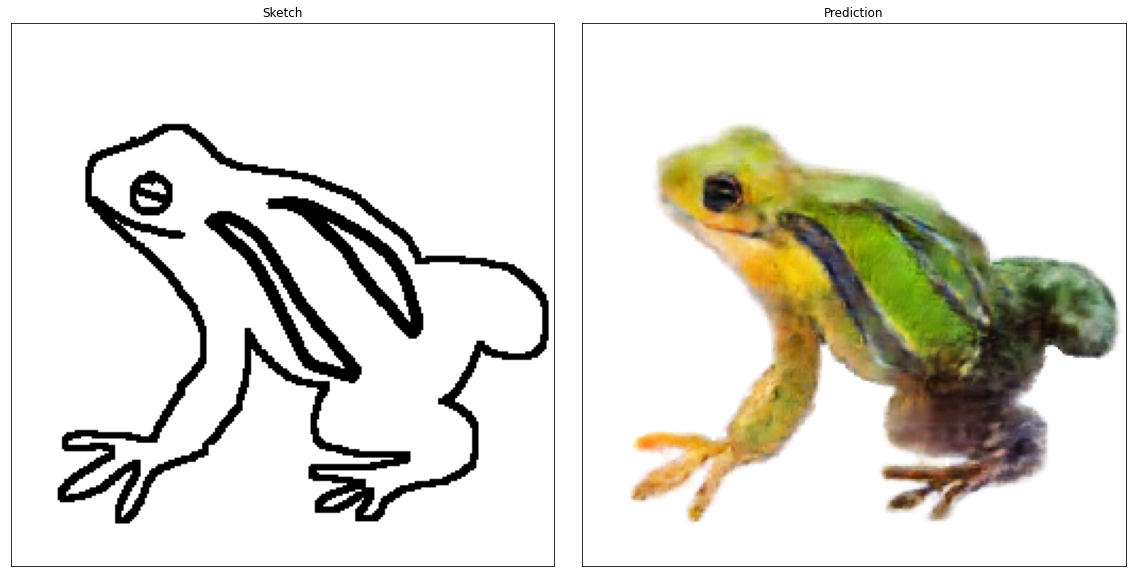

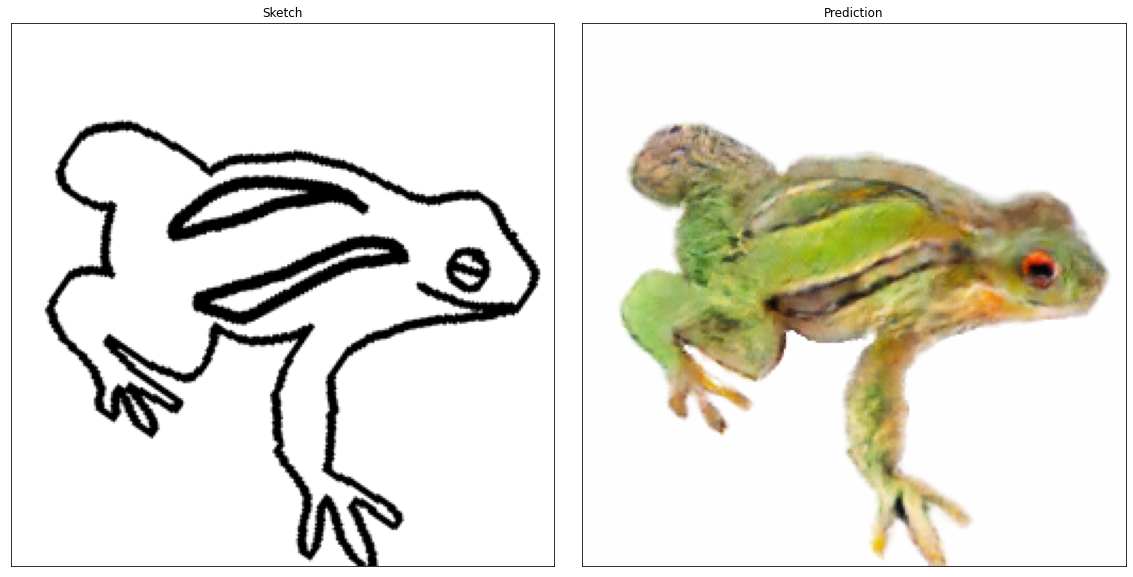

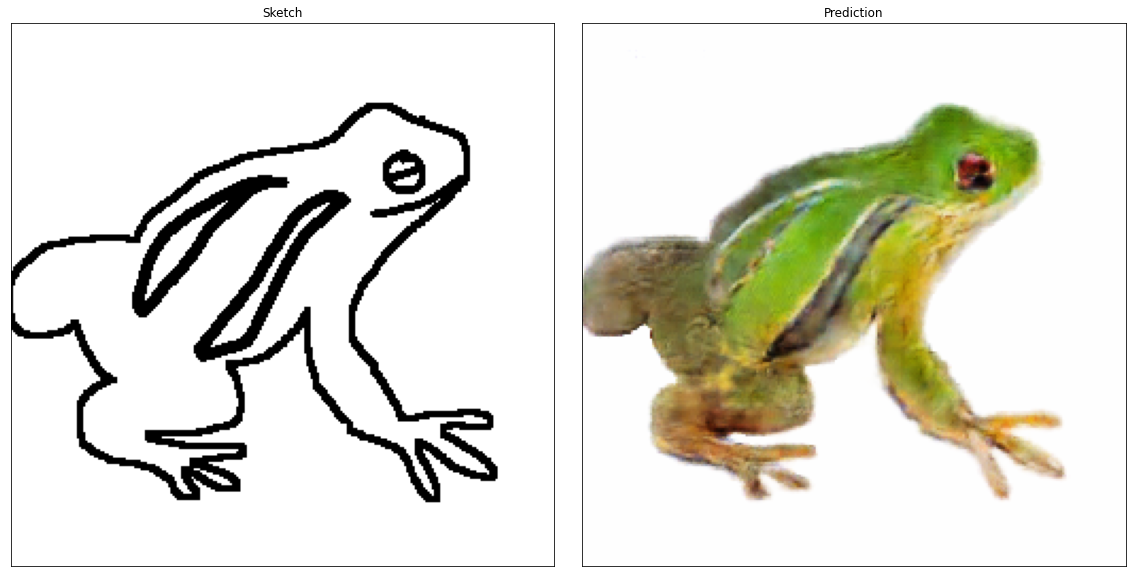

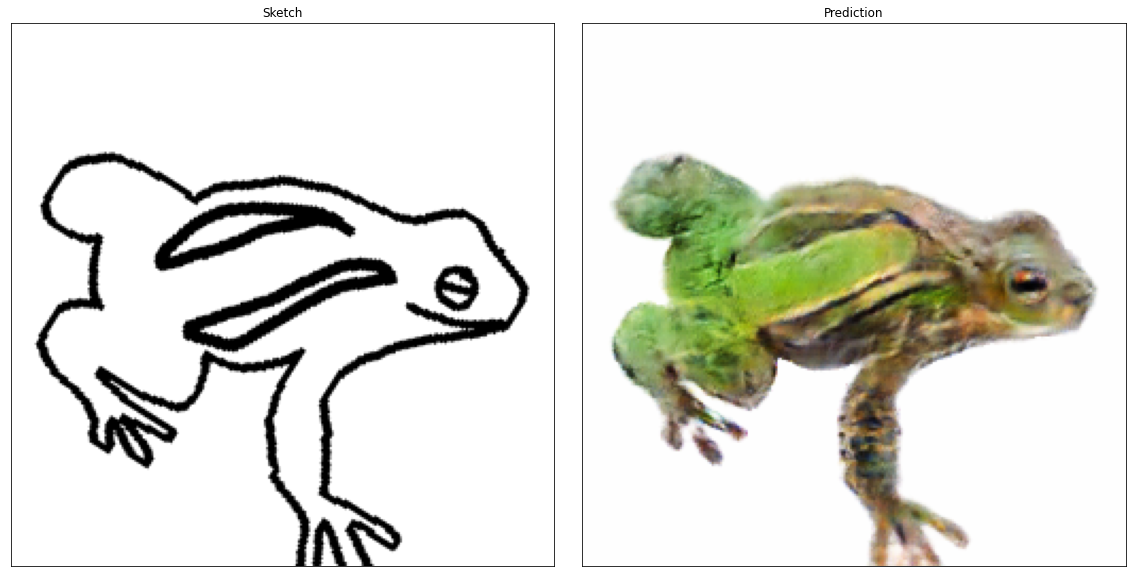

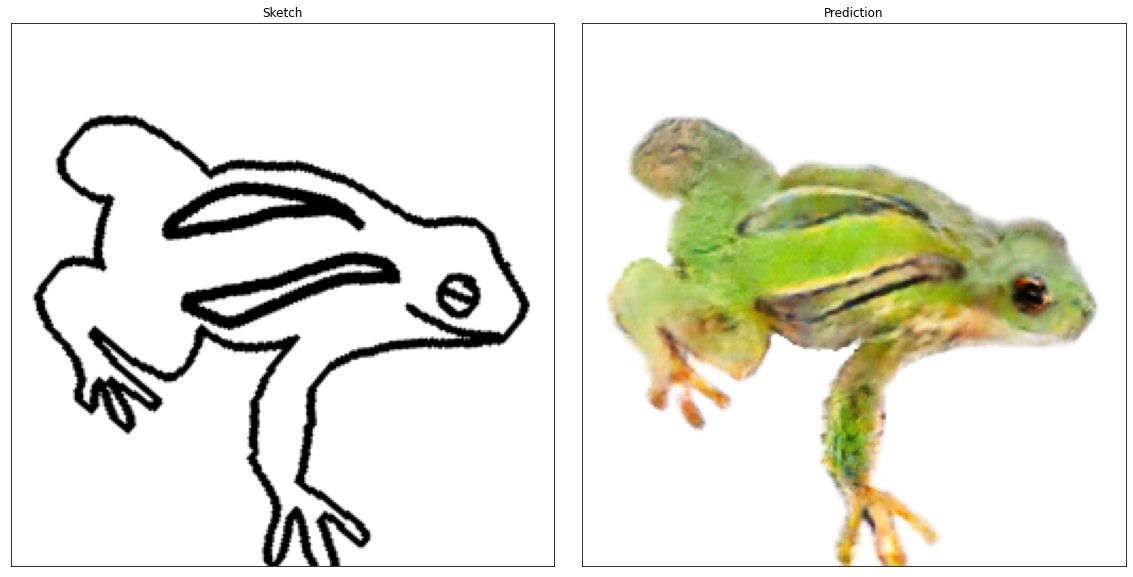

In [32]:
# for i in range(20):
#     for filepath in EXAMPLES_DIR.glob('For Report/*.png'): # 'frog-sketch-[0-9].png' '*[.png|.jpg]'
#         save_dir = EXAMPLES_DIR / 'For Report' / 'Preds - DS3'
#         fname = filepath.name[:-4] + f'-{i:02d}' + filepath.suffix
#         predict_and_show(model, filepath, image_shape=IMAGE_SHAPE, thicken=0, size=10, aug=True, save=save_dir/fname, show=False)

for i in range(5):
    for filepath in EXAMPLES_DIR.glob('For Report/DS3/2.png'): # 'frog-sketch-[0-9].png' '*[.png|.jpg]'
        predict_and_show(model, filepath, image_shape=IMAGE_SHAPE, thicken=0, size=10, aug=True, show=True)

It is sensitive to line width.